In [178]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [179]:
import io
import base64
import time
from functools import partial
from typing import NamedTuple
import subprocess

import PIL
import numpy as np
import matplotlib.pylab as pl

from IPython.display import display, Image, HTML

from tqdm import tqdm

In [180]:
# from jax.config import config
# config.enable_omnistaging()

In [181]:
def np2pil(a):
    if a.dtype in [np.float32, np.float64]:
        a = np.uint8(np.clip(a, 0, 1) * 255)
    return PIL.Image.fromarray(a)


def imwrite(f, a, fmt=None):
    a = np.asarray(a)
    if isinstance(f, str):
        fmt = f.rsplit(".", 1)[-1].lower()
        if fmt == "jpg":
            fmt = "jpeg"
        f = open(f, "wb")
    np2pil(a).save(f, fmt, quality=95)


def imshow(a, fmt="jpeg", display=display):
    return display(Image(data=imencode(a, fmt)))


def imencode(a, fmt="jpeg"):
    a = np.asarray(a)
    if len(a.shape) == 3 and a.shape[-1] == 4:
        fmt = "png"
    f = io.BytesIO()
    imwrite(f, a, fmt)
    return f.getvalue()

In [182]:
import jax
import jax.numpy as jp


def norm(v, axis=-1, keepdims=False, eps=0.0):
    return jp.sqrt((v * v).sum(axis, keepdims=keepdims).clip(eps))


def normalize(v, axis=-1, eps=1e-20):
    return v / norm(v, axis, keepdims=True, eps=eps)

In [183]:
# np.save("./bunny_boundary_nodes.npy", scene.boundary_nodes)
# np.save("./contact_boundary.npy", scene.boundaries.contact_boundary)

boundary_nodes = np.load("./bunny_boundary_nodes2.npy")
contact_boundary = np.load("./contact_boundary2.npy")

boundaries = boundary_nodes[contact_boundary]
boundaries.shape

(15514, 3, 3)

In [189]:
def triangle_sfd_jax(point, triangle, thickness=0.01):
    # TODO:  add batching and additional argument with current minimum to test against

    # TODO:  inline
    def dot2(v):
        return jp.dot(v, v)

    v1, v2, v3 = triangle
    v21, p1 = v2 - v1, point - v1
    v32, p2 = v3 - v2, point - v2
    v13, p3 = v1 - v3, point - v3
    nor = jp.cross(v21, v13)

    test = (
        jp.sign(jp.dot(jp.cross(v21, nor), p1))
        + jp.sign(jp.dot(jp.cross(v32, nor), p2))
        + jp.sign(jp.dot(jp.cross(v13, nor), p3))
    )
    # # inside/outside test

    # 3 edges
    # TODO:  move outside
    def val_3_edges():
        return jp.min(
            jp.array(
                [
                    dot2(v21 * jp.clip(jp.dot(v21, p1) / dot2(v21), 0.0, 1.0) - p1),
                    dot2(v32 * jp.clip(jp.dot(v32, p2) / dot2(v32), 0.0, 1.0) - p2),
                    dot2(v13 * jp.clip(jp.dot(v13, p3) / dot2(v13), 0.0, 1.0) - p3),
                ]
            )
        )

    # single face
    def val_single_face():
        return jp.dot(nor, p1) * jp.dot(nor, p1) / dot2(nor)

    val = jp.where(test < 2.0, val_3_edges(), val_single_face())
    return jp.abs(jp.sqrt(val)) - thickness

In [190]:
def bunny_sdf(boundaries, point):
    bunny_dist = jax.vmap(partial(triangle_sfd_jax, point))(boundaries).min()
    floor_dist = point[2] + 4.0
    return jp.minimum(bunny_dist, floor_dist)

In [191]:
def raycast(sdf, p0, dir, step_n=50):
    # print("raycast")
    def f(_, p):
        return p + sdf(p) * dir

    return jax.lax.fori_loop(0, step_n, f, p0)

In [192]:
world_up = jp.array([0.0, 0.0, 1.0])


def camera_rays(forward, view_size, fx=0.3):
    right = jp.cross(forward, world_up)
    down = jp.cross(right, forward)
    R = normalize(jp.vstack([right, down, forward]))
    w, h = view_size
    fy = fx / w * h
    y, x = jp.mgrid[fy : -fy : h * 1j, -fx : fx : w * 1j].reshape(2, -1)
    return normalize(jp.c_[x, y, jp.ones_like(x)]) @ R


w, h = 1000, 1000  # 1280, 800
h_batch = h // 20  # 400

# w, h = 250, 125
# h_batch = h

pos0 = jp.float32([2.5, 3, 3.5])
forward = jp.float32([-2, -2, -2])
ray_dir = camera_rays(forward, view_size=(w, h))

sdf = partial(bunny_sdf, boundaries)  # jax.jit() scene_sdf
# sdf(ray_dir_batch[1])

# get_hit_pos_jax = jax.soft_pmap(partial(raycast, sdf, pos0))
# get_raw_normal_jax = jax.soft_pmap(jax.grad(sdf))

get_hit_pos_jax = jax.pmap(jax.vmap(partial(raycast, sdf, pos0)))
get_raw_normal_jax = jax.pmap(jax.vmap(jax.grad(sdf)))

# get_hit_pos_jax = jax.jit(jax.vmap(partial(raycast, sdf, pos0)))
# get_raw_normal_jax = jax.jit(jax.vmap(jax.grad(sdf)))

100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


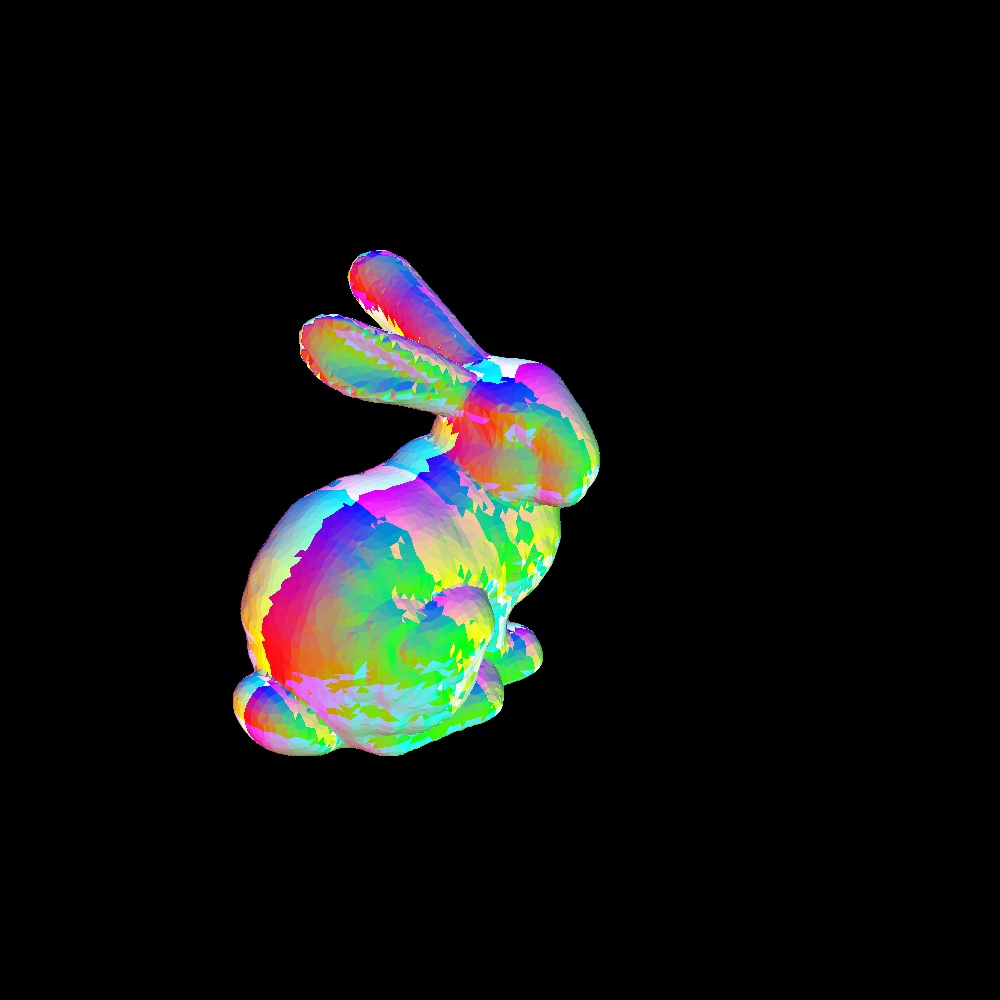

In [193]:
# strip = (w * h_batch)
# ray_dir_batches = jp.array([ray_dir[i*strip:(i+1)*strip] for i in range(0, (h // h_batch))])
# ray_dir_batches.shape
# # _ = fun(jp.zeros(3, dtype = np.float32))

device_count = 2
out = None
strip = w * h_batch
for i in tqdm(range(0, (h // h_batch))):
    ray_dir_batch = ray_dir[i * strip : (i + 1) * strip]
    ray_dir_batch = ray_dir_batch.reshape(device_count, -1, 3)
    hit_pos_part = get_hit_pos_jax(ray_dir_batch)  # pmap?
    raw_normal = get_raw_normal_jax(hit_pos_part)
    # norm(raw_normal)

    out_part = raw_normal
    out = out_part if out is None else np.vstack([out, out_part])

imshow(out.reshape(h, w, 3) % 1.0)
# Camera looking in the distance - rgb noise is from rays that didn't travell to infinity increase marching steps

In [ ]:
# np.save("./bunny_boundary_nodes.npy", scene.boundary_nodes)
# np.save("./contact_boundary.npy", scene.boundaries.contact_boundary)

boundary_nodes = np.load("./bunny_boundary_nodes2.npy")
contact_boundary = np.load("./contact_boundary2.npy")

boundaries = boundary_nodes[contact_boundary]
boundaries.shape

(15514, 3, 3)

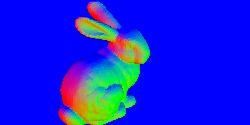

In [ ]:
raw_normal = jax.soft_pmap(jax.grad(sdf))(hit_pos_part)
imshow(raw_normal.reshape(h_batch, w, 3))

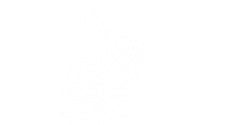

In [ ]:
imshow(norm(raw_normal).reshape(h_batch, w))

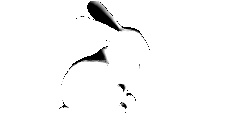

In [ ]:
def cast_shadow(sdf, light_dir, p0, step_n=50, hardness=8.0):
    def f(_, carry):
        t, shadow = carry
        h = sdf(p0 + light_dir * t)
        return t + h, jp.clip(hardness * h / t, 0.0, shadow)

    return jax.lax.fori_loop(0, step_n, f, (1e-2, 1.0))[1]


light_dir = normalize(jp.array([1.1, 1.0, 0.2]))
shadow = jax.soft_pmap(partial(cast_shadow, sdf, light_dir))(hit_pos_part)  # vmap
imshow(shadow.reshape(h_batch, w))

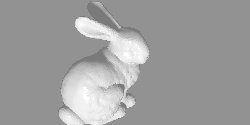

In [ ]:
def shade_f(surf_color, shadow, raw_normal, ray_dir, light_dir):
    ambient = norm(raw_normal)
    normal = raw_normal / ambient
    diffuse = normal.dot(light_dir).clip(0.0) * shadow
    half = normalize(light_dir - ray_dir)
    spec = 0.3 * shadow * half.dot(normal).clip(0.0) ** 200.0
    light = 0.7 * diffuse + 0.2 * ambient
    return surf_color * light + spec


f = partial(shade_f, jp.ones(3), light_dir=light_dir)
frame = jax.soft_pmap(f)(shadow, raw_normal, ray_dir_batch)
frame = frame ** (1.0 / 2.2)  # gamma correction
imshow(frame.reshape(h_batch, w, 3))